# Big Data Platforms - MSCA 31013 - 2
## Twitter - Covid Project
## Muhammad Ali Ahmad

**Table of Contents:** <br>
    
    1. Setting up Environment 
    2. Reading in our Entire Twitter Dataset
    3. Geographical Distribution of Covid Tweets 
    4. Loading Sample Data and Performing Necessary Preprocessing
    5. Identifying the Most Prolific/Influential Twitterers
        A. Top Accounts by Followers 
        B. Top Account by Number of Tweets
        C. Top Accounts by Number of Retweets
    6. Observing Timeline of the Tweets with Peaks and Valleys 
        A. Monthly Distribution of Tweets
        B. Daily Distribution of Tweets for Different Months
    7. Message Uniqueness Analysis
        A. K = 20 
        B. K = 17 
        C. K = 15
        D. K = 12
        E. K = 10
    8. US Case Study: Understanding Relationship between Tweets and Covid Progression
    9. Appendix

**Dataframe reference:** <br> 
    **1. tweets_df:** all tweets available in our source directory <br> 
    **2. tweets_country:** all tweets but with only select columns (country, created_at, text, place.country) <br>
    **3. country_distribution:** number of tweets per country <br> 
    **3. df_sample_covid:** tweets_country filtered for covid related tweets <br> 
    **4. sample_df:** 1% of sampled data of source directory <br> 
    **5. sampled_followers:** created from sample_df, containing only select columns (name, user.id, followers_count, text, created_at) <br> 
    **6. tweet_follower:** displays name of twitter account and the follower count <br>  
    
**Parquet files:** <br> 
    **1. sample_df:** A sample containing 1% of the source data <br> 
    **2. US_CT_Df:** Contains information regarding US Covid Tweet activity and Cases <br> 
    **3. US_CT_Df_Updated:** Contains information regarding US Covid Related Tweet activity after making further updates <br> 
    **4. tweet_follower:** Contains the followers count for each account, sorted in descending order <br> 

### 1. Setting up Environment 

In [21]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import pandas as pd

In [22]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### 2. Reading in our Entire Twitter Dataset

In [23]:
directory = 'gs://msca-bdp-tweets/final_project/'
path = directory

In [24]:
%%time
tweets_df = spark.read.json(path)

22/03/20 02:14:24 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


CPU times: user 1.83 s, sys: 495 ms, total: 2.33 s
Wall time: 9min 15s


### 3. Geographical Distribution of Covid Tweets

In [25]:
tweets_country = tweets_df.select('place.country', 'created_at', 'text')

In [26]:
tweets_country = tweets_country.na.drop(subset = 'country')

**Filtering for the relevant keywords**

In [27]:
tweets_country.createOrReplaceTempView('temp')
df_sample_covid = spark.sql("select * from temp where text like '%corona%' \
          or text like '%covid%' \
          or text like '%pandemic%' \
          or text like '%delta%' \
          or text like '%omicron%' \
          or text like '%SARS-CoV-2%'")

**Grouping by country and obtaining tweet count for each country**

In [28]:
df_sample_covid.createOrReplaceTempView('temp')
country_distribution = spark.sql("Select Country, Count(*) as Freq From temp Group by 1 Order by Freq Desc")

In [30]:
country_distribution.write.format('parquet').save('gs://msca-bdp-students-bucket/shared_data/aliahmad/country_wise_covid_tweets')

In [10]:
path = 'gs://msca-bdp-students-bucket/shared_data/aliahmad/country_wise_covid_tweets'

In [11]:
country_distribution = spark.read.parquet(path)

In [ ]:
country_distribution = country_distribution.toPandas()

In [127]:
country_distribution.head(20)

,Country,Freq
0,United States,42592
1,United Kingdom,19357
2,Canada,4787
3,India,4462
4,Australia,4049
5,Ireland,2029
6,South Africa,1635
7,New Zealand,817
8,Republic of the Philippines,657
9,Malaysia,404


In [201]:
top_countries = country_distribution.head(10)

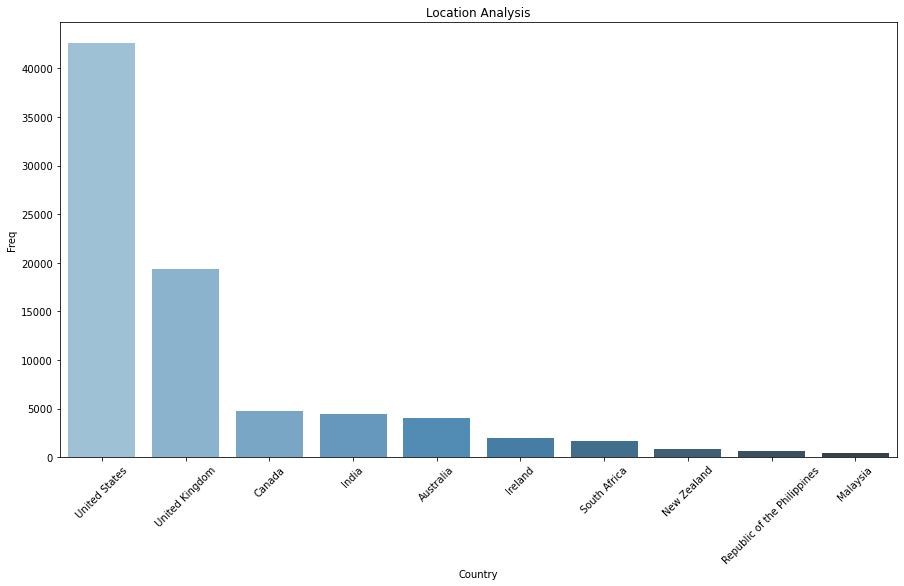

In [202]:
import seaborn as sns

plt.figure(figsize = (15,8))
ax = sns.barplot(x = "Country", y = "Freq", data = top_countries, palette = "Blues_d").set(title = 'Location Analysis - Top 20')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);

**Getting Distribution of Tweets Per Country Per Month** 

In [31]:
df_sample_covid = df_sample_covid.withColumn('year', split(df_sample_covid['created_at'], ' ').getItem(5)) \
        .withColumn('month', split(df_sample_covid['created_at'], ' ').getItem(1)) \
        .withColumn('day', split(df_sample_covid['created_at'], ' ').getItem(2))

In [32]:
df_sample_covid.createOrReplaceTempView('temp')
country_distribution = spark.sql("Select Country, Count(*) as Freq From temp Group by 1 Order by Freq Desc")

In [34]:
type(country_distribution)

pyspark.sql.dataframe.DataFrame

In [124]:
country_distribution = country_distribution.toPandas()

pyspark.sql.dataframe.DataFrame

In [57]:
tweets_timeline = spark.sql('SELECT country, year, month, count(*) as num_tweets from tmp group by 1, 2, 3 order by 1, 2, 3')

In [ ]:
tweets_timeline.limit(20)

country,year,month,num_tweets
,2021,Nov,1
Afghanistan,2021,Nov,1
Albania,2021,Dec,1
Albania,2021,Oct,1
Algeria,2021,Dec,2
Algeria,2022,Jan,1
Algérie,2022,Jan,1
An Rioghachd Aona...,2022,Jan,1
Andorra,2021,Dec,2
Andorra,2022,Jan,2


**Filtering our Dataset to look at the US**

In [35]:
df_sample_covid.createOrReplaceTempView('tmp')
tweets_US_timelines = spark.sql('SELECT country, year, month, day, count(*) as num_tweets from tmp \
                                 WHERE country = "United States" group by 1, 2, 3, 4 order by 1, 2, 3, 4')

In [13]:
%%time
tweets_US_timelines.limit(100)

CPU times: user 1.64 ms, sys: 376 µs, total: 2.02 ms
Wall time: 6.39 ms


DataFrame[country: string, year: string, month: string, day: string, num_tweets: bigint]

In [ ]:
%%time
tweets_US_timelines_pd = tweets_US_timelines.toPandas()

In [ ]:
type(tweets_US_timelines_pd)

**We will be extracting daily covid related data for the US from the following link:** <br>
    https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv

In [36]:
covid_cases = pd.read_csv('gs://msca-bdp-students-bucket/shared_data/aliahmad/US_Covid_Data.csv')
type(covid_cases)

pandas.core.frame.DataFrame

In [37]:
covid_cases.head(5)

,date,cases,deaths,Day_1,Month_1,Year_1,Country_1,Monthname_1,Week,Day_Cases,Day_Deaths
0,1/21/20,1,0,21,1,2020,United States,Jan,4,1,0
1,1/22/20,1,0,22,1,2020,United States,Jan,4,0,0
2,1/23/20,1,0,23,1,2020,United States,Jan,4,0,0
3,1/24/20,2,0,24,1,2020,United States,Jan,4,1,0
4,1/25/20,3,0,25,1,2020,United States,Jan,4,1,0


**Combining Dataframes**

In [39]:
# tweets_spark = spark.createDataFrame(tweets_US_timeline_pd) 
covid_spark = spark.createDataFrame(covid_cases) 

In [40]:
tweets_US_timelines.createOrReplaceTempView('tweets')
covid_spark.createOrReplaceTempView('covid')

combined_df = tweets_US_timelines.join(covid_spark, (tweets_US_timelines.day == covid_spark.Day_1) & (tweets_US_timelines.month == covid_spark.Monthname_1) & (tweets_US_timelines.year == covid_spark.Year_1))

In [41]:
type(combined_df)

pyspark.sql.dataframe.DataFrame

In [42]:
combined_df.show(10)

+-------------+----+-----+---+----------+--------+--------+------+-----+-------+------+-------------+-----------+----+---------+----------+
|      country|year|month|day|num_tweets|    date|   cases|deaths|Day_1|Month_1|Year_1|    Country_1|Monthname_1|Week|Day_Cases|Day_Deaths|
+-------------+----+-----+---+----------+--------+--------+------+-----+-------+------+-------------+-----------+----+---------+----------+
|United States|2022|  Jan| 22|       255| 1/22/22|70468314|865116|   22|      1|  2022|United States|        Jan|   4|   337384|       934|
|United States|2022|  Jan| 21|       302| 1/21/22|70130930|864182|   21|      1|  2022|United States|        Jan|   4|   825315|      3866|
|United States|2021|  Nov| 22|       205|11/22/21|47851516|773402|   22|     11|  2021|United States|        Nov|  48|   158898|      1233|
|United States|2021|  Nov| 05|       357| 11/5/21|46395310|753734|    5|     11|  2021|United States|        Nov|  45|    91768|      2321|
|United States|2021|

In [43]:
%%time
combined_df.write.format('parquet').save('gs://msca-bdp-students-bucket/shared_data/aliahmad/US_CT_Df_Updated')

CPU times: user 787 ms, sys: 296 ms, total: 1.08 s
Wall time: 4min 2s


In [ ]:
%%time
combined_df = combined_df.toPandas()

CPU times: user 845 ms, sys: 221 ms, total: 1.07 s
Wall time: 3min 49s


In [47]:
combined_df = combined_df.drop(columns=['Day_1', 'Year_1', 'Monthname_1'])

In [49]:
combined_df.head(5)

,country,year,month,day,num_tweets,date,cases,deaths,Month_1,Country_1,Week,Day_Cases,Day_Deaths
0,United States,2022,Jan,22,255,1/22/22,70468314,865116,1,United States,4,337384,934
1,United States,2022,Jan,21,302,1/21/22,70130930,864182,1,United States,4,825315,3866
2,United States,2021,Nov,22,205,11/22/21,47851516,773402,11,United States,48,158898,1233
3,United States,2021,Nov,05,357,11/5/21,46395310,753734,11,United States,45,91768,2321
4,United States,2021,Nov,17,229,11/17/21,47390261,766489,11,United States,47,114357,1618


In [58]:
combined_df.write.format('parquet').save('gs://msca-bdp-students-bucket/shared_data/aliahmad/US_CT_Df')

### 4. Loading Sample Data and Performing Necessary Preprocessing

In [92]:
%%time
sample_df = tweets_df.sample(False, 0.01, seed = 123)

CPU times: user 2.06 ms, sys: 454 µs, total: 2.52 ms
Wall time: 8.4 ms


In [93]:
sample_df.write.format('parquet').save('gs://msca-bdp-students-bucket/shared_data/aliahmad/sample_df')

**Displaying sample file size**

In [1]:
!hadoop fs -du -s -h 'gs://msca-bdp-students-bucket/shared_data/aliahmad/sample_df'

4.7 G  4.7 G  gs://msca-bdp-students-bucket/shared_data/aliahmad/sample_df


In [2]:
path = 'gs://msca-bdp-students-bucket/shared_data/aliahmad/sample_df'

**Reading in our Data**

In [3]:
%%time
sample_df = spark.read.parquet(path)

CPU times: user 8.25 ms, sys: 2.07 ms, total: 10.3 ms
Wall time: 7.91 s


22/03/19 21:32:17 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


**Necessary Preprocessing**

In [4]:
sampled_followers = sample_df.select('user.name','user.id', 'user.followers_count', 'text', 'created_at')

In [5]:
sampled_followers.createOrReplaceTempView('temp')
sampled_followers = spark.sql("select * from temp where text like '%corona%' \
          or text like '%covid%' \
          or text like '%pandemic%' \
          or text like '%delta%' \
          or text like '%omicron%' \
          or text like '%SARS-CoV-2%'")

In [6]:
sampled_followers.count()

163623

### 5. Identifying the Most Profific/Influential Twitterers

#### 5A. Top Accounts by Followers

In [8]:
# create new columns indicating the year, month and day of the tweeets
sampled_followers = sampled_followers.withColumn('year', split(sampled_followers['created_at'], ' ').getItem(5)) \
       .withColumn('month', split(sampled_followers['created_at'], ' ').getItem(1)) \
       .withColumn('day', split(sampled_followers['created_at'], ' ').getItem(2))

In [9]:
sampled_followers.columns

['name', 'id', 'followers_count', 'text', 'created_at', 'year', 'month', 'day']

In [10]:
sampled_followers.createOrReplaceTempView('tmp')
tweet_follower = spark.sql('SELECT name, MAX(followers_count) as Follow_Count FROM tmp GROUP BY id, name ORDER BY MAX(followers_count) DESC')

In [11]:
%%time
tweet_follower = tweet_follower.toPandas()

CPU times: user 1.15 s, sys: 114 ms, total: 1.26 s
Wall time: 2min 16s


In [12]:
tweet_follower.head(20)

,name,Follow_Count
0,The Economist,26128878
1,Reuters,24200550
2,The Washington Post,18605788
3,ABC News,16988208
4,NDTV,16547261
5,The Times Of India,14199096
6,BBC News (UK),12963014
7,CNN International,12874995
8,World Health Organization (WHO),10598090
9,The Guardian,10040481


Within our dataframe, we can observe the most influential twitter accounts by the tweet name. <br> 
We can observe that the most highly followed twitter accounts are those belonging to news and media outlets. 

In [14]:
tweet_follower = spark.createDataFrame(tweet_follower) 

In [15]:
%%time
tweet_follower.write.format('parquet').save('gs://msca-bdp-students-bucket/shared_data/aliahmad/tweet_follower')

22/03/19 21:37:11 WARN org.apache.spark.scheduler.TaskSetManager: Stage 9 contains a task of very large size (1788 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 8.59 ms, sys: 42 µs, total: 8.63 ms
Wall time: 3.32 s


#### 5B. Top Accounts by Number of Tweets

**Filtering for a minimum threshold follower count**

In [28]:
tweet_number = spark.sql('SELECT name, MAX(followers_count) as Follow_Count, Count(*) Tweets FROM tmp WHERE followers_count > 500000 \
                          GROUP BY name \
                          ORDER BY Tweets DESC')

In [31]:
tweet_number = tweet_number.toPandas()

In [35]:
tweet_number.head(20)

,name,Follow_Count,Tweets
0,Mint,2016156,5
1,IndiaToday,5905441,5
2,New Scientist,4068241,5
3,Dawn.com,1235334,4
4,The Jerusalem Post,544598,4
5,CNBC,4461736,4
6,World Health Organization (WHO),10598090,4
7,Thread Reader App,523584,4
8,Inquirer,3410945,3
9,Philstar.com,795781,3


**Not filtering for a minimum threshold follower count**

In [37]:
tweet_number_1 = spark.sql('SELECT name, MAX(followers_count) as Follow_Count, Count(*) Tweets FROM tmp  \
                            GROUP BY name \
                            ORDER BY Tweets DESC')

In [38]:
tweet_number_1 = tweet_number_1.toPandas()

In [39]:
tweet_number_1.head(20)

,name,Follow_Count,Tweets
0,.,13846,171
1,ً,40578,157
2,Coronavirus Updates,1366,102
3,Chris,2174,87
4,Mike,14958,78
5,John,7861,71
6,David,15166,69
7,Matt,52902,65
8,James,11960,64
9,Alex,5943,64


#### 5C. Top Accounts by Number of Retweets

In [45]:
retweet_info = sample_df.select('user.name','user.id', 'user.followers_count', 'text', 'created_at', 'retweeted_status', 'retweet_count')

In [46]:
retweet_info.createOrReplaceTempView('tmp')
retweet_count = spark.sql('SELECT name, AVG(retweet_count) as avg_retweet_count FROM tmp WHERE retweet_count IS NOT NULL GROUP BY name ORDER BY AVG(retweet_count) DESC')

In [47]:
retweet_count = retweet_count.toPandas()

In [49]:
retweet_count.head(10)

,name,avg_retweet_count
0,Matlho,0.0
1,DatArsenal,0.0
2,emilygebbie,0.0
3,i’m AWOKE,0.0
4,J𝕒𝕪シ (NETS2022CHAMPIONS🏆),0.0
5,laki0814,0.0
6,Anna Mation,0.0
7,elsa,0.0
8,Rachel Burgess,0.0
9,Gutru,0.0


The variable retweet count does not seem to be populated in the correct manner.

### 6. Observing Timeline of the Tweets with Peaks and Valleys 

In [56]:
df_timeframes = df_sample_covid.select('year','month','day')

In [57]:
df_timeframes.createOrReplaceTempView("temp")
df_timeline_month = spark.sql('SELECT month, count(*) as num_tweets from temp group by 1 order by 2')

In [ ]:
df_timeline_overall = spark.sql('SELECT year, month, count(*) as num_tweets from temp group by 1,2 order by 1,2') 
df_timeline_oct = spark.sql('SELECT day, count(*) as num_tweets from temp WHERE month = "Oct" group by 1 order by 2')
df_timeline_nov = spark.sql('SELECT day, count(*) as num_tweets from temp WHERE month = "Nov" group by 1 order by 2')
df_timeline_dec = spark.sql('SELECT day, count(*) as num_tweets from temp WHERE month = "Dec" group by 1 order by 2')
df_timeline_jan = spark.sql('SELECT day, count(*) as num_tweets from temp WHERE month = "Jan" group by 1 order by 2')

In [58]:
%%time
df_timeline_month = df_timeline_month.toPandas()

CPU times: user 1.22 s, sys: 389 ms, total: 1.61 s
Wall time: 6min 32s


In [97]:
df_timeline_overall = df_timeline_overall.toPandas()
df_timeline_oct = df_timeline_oct.toPandas()
df_timeline_nov = df_timeline_nov.toPandas()
df_timeline_dec = df_timeline_dec.toPandas()
df_timeline_jan = df_timeline_jan.toPandas()

In [60]:
df_timeline_month = df_timeline_month.reindex([0, 1, 3, 2])
df_timeline_month.head()

,month,num_tweets
0,Oct,9062
1,Nov,17423
3,Dec,39103
2,Jan,25733


#### 6A. Monthly Distribution of Tweets

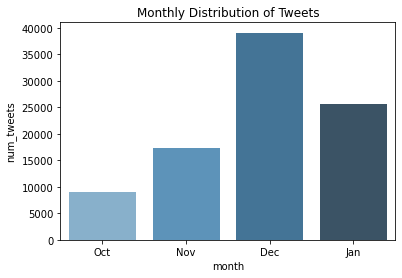

In [61]:
ax = sns.barplot(x = "month", y = "num_tweets", data = df_timeline_month, palette = "Blues_d").set(title = 'Monthly Distribution of Tweets')

#### 6B. Daily Distribution of Tweets for Different Months

**October**

In [111]:
df_timeline_oct = df_timeline_oct.sort_values(by=['day'])

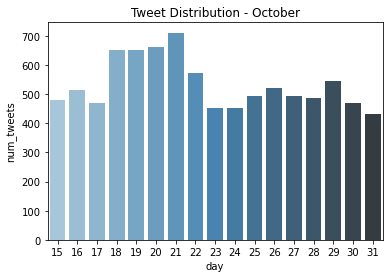

In [112]:
ax = sns.barplot(x = "day", y = "num_tweets", data = df_timeline_oct, palette = "Blues_d").set(title = 'Tweet Distribution - October')

**November**

In [113]:
df_timeline_nov = df_timeline_nov.sort_values(by=['day'])

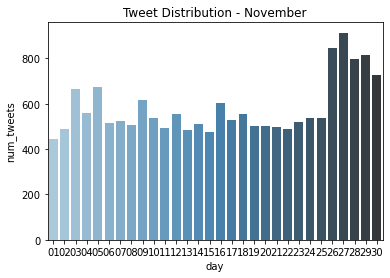

In [114]:
ax = sns.barplot(x = "day", y = "num_tweets", data = df_timeline_nov, palette = "Blues_d").set(title = 'Tweet Distribution - November')

**December**

In [115]:
df_timeline_dec = df_timeline_dec.sort_values(by=['day'])

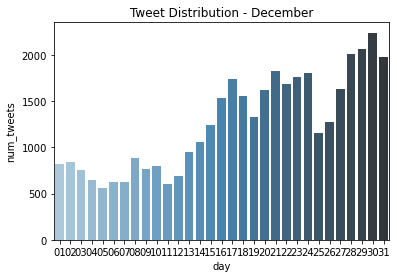

In [116]:
ax = sns.barplot(x = "day", y = "num_tweets", data = df_timeline_dec, palette = "Blues_d").set(title = 'Tweet Distribution - December')

**January**

In [117]:
df_timeline_jan = df_timeline_jan.sort_values(by=['day'])

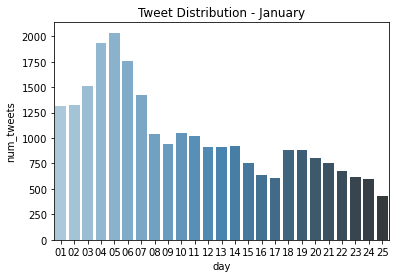

In [118]:
ax = sns.barplot(x = "day", y = "num_tweets", data = df_timeline_jan, palette = "Blues_d").set(title = 'Tweet Distribution - January')

### 7. Message Uniqueness Analysis

In [27]:
import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.functions import *
from pyspark.sql.types import *

import re
import builtins as p
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

In [5]:
!pip install simhash

In [28]:
from simhash import Simhash, SimhashIndex

In [29]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
path = 'gs://msca-bdp-students-bucket/shared_data/aliahmad/sample_df'

In [31]:
%%time
sample_df = spark.read.parquet(path)

CPU times: user 3.64 ms, sys: 0 ns, total: 3.64 ms
Wall time: 1.55 s


In [32]:
sample_df.createOrReplaceTempView('temp')
sample_df = spark.sql("select * from temp where text like '%corona%' \
          or text like '%covid%' \
          or text like '%pandemic%' \
          or text like '%delta%' \
          or text like '%omicron%' \
          or text like '%SARS-CoV-2%'")

In [33]:
%%time
Uniqueness_df = sample_df.select(['text']).toPandas()

CPU times: user 1.17 s, sys: 73.2 ms, total: 1.24 s
Wall time: 2min 4s


In [34]:
Uniqueness_df.shape

(163623, 1)

In [35]:
Uniqueness_df.head(5)

,text
0,"RT @snktjain: Dear @firstpost, I was applying ..."
1,RT @8EightPillars: Thats the Bat that started ...
2,800K Americans dead from #coronavirus. Article...
3,@BadVaccineTakes I would feel bad for covid tb...
4,RT @Indijxde: @ZubyMusic My mother in law work...


In [36]:
data = Uniqueness_df['text'].to_dict()
data_first = {k: data[k] for k in list(data)[:5]}
data_first

{0: "RT @snktjain: Dear @firstpost, I was applying for Ram Nath Goenka Awards for the covid stories I had written for you. It's unfortunate to s…",
 1: 'RT @8EightPillars: Thats the Bat that started covid',
 2: '800K Americans dead from #coronavirus. Article 61. https://t.co/ycjKMCR9fc #joerogan #BillMaher #chrisrock #icecube… https://t.co/7VphlhCfYK',
 3: '@BadVaccineTakes I would feel bad for covid tbh 😕 https://t.co/nkUCNBWtCn',
 4: 'RT @Indijxde: @ZubyMusic My mother in law works in the hospital and worked on covid ward. She was told to put covid as death even when they…'}

In [37]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(p.max(len(s) - width + 1, 1))]

In [38]:
keyword = 'covid'

#### 7A. K = 20

In [17]:
%%time

objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index = SimhashIndex(objs, k = 20)

print(index.bucket_size())

176
CPU times: user 58.3 s, sys: 339 ms, total: 58.6 s
Wall time: 58.6 s


In [18]:
s = Simhash(get_features(keyword))
s_dups = index.get_near_dups(s)

Uniqueness_df.iloc[s_dups].shape

Big bucket found. key:0:0, len:38197
Big bucket found. key:4:1, len:24245
Big bucket found. key:6:2, len:32377
Big bucket found. key:2:3, len:35662
Big bucket found. key:0:4, len:28426
Big bucket found. key:5:5, len:23493
Big bucket found. key:7:6, len:18003
Big bucket found. key:3:7, len:24596
Big bucket found. key:3:8, len:41479
Big bucket found. key:3:9, len:35786
Big bucket found. key:7:a, len:33460
Big bucket found. key:0:b, len:36731
Big bucket found. key:5:c, len:31530
Big bucket found. key:3:d, len:32908
Big bucket found. key:7:e, len:21163
Big bucket found. key:7:f, len:18110
Big bucket found. key:1:10, len:38142
Big bucket found. key:2:11, len:30362
Big bucket found. key:3:12, len:27601
Big bucket found. key:2:13, len:22696
Big bucket found. key:0:14, len:15669


(7680, 1)

#### 7B. K = 17

In [39]:
%%time

objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index = SimhashIndex(objs, k = 17)

print(index.bucket_size())

7988
CPU times: user 50.1 s, sys: 263 ms, total: 50.3 s
Wall time: 50.3 s


In [40]:
s = Simhash(get_features(keyword))
s_dups = index.get_near_dups(s)

Uniqueness_df.iloc[s_dups].shape

Big bucket found. key:0:0, len:38197
Big bucket found. key:4:1, len:24245
Big bucket found. key:6:2, len:32377
Big bucket found. key:2:3, len:35662
Big bucket found. key:0:4, len:28426
Big bucket found. key:5:5, len:23493
Big bucket found. key:7:6, len:18003
Big bucket found. key:3:7, len:24596
Big bucket found. key:3:8, len:41479
Big bucket found. key:3:9, len:35786
Big bucket found. key:7:a, len:33460
Big bucket found. key:0:b, len:36731
Big bucket found. key:5:c, len:31530
Big bucket found. key:3:d, len:32908
Big bucket found. key:7:e, len:21163
Big bucket found. key:7:f, len:18110
Big bucket found. key:1:10, len:38142


(1281, 1)

#### 7C. K = 15

In [19]:
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index = SimhashIndex(objs, k = 15)

print (index.bucket_size())

256


In [20]:
s = Simhash(get_features(keyword))
s_dups = index.get_near_dups(s)
Uniqueness_df.iloc[s_dups].shape

Big bucket found. key:0:0, len:19707
Big bucket found. key:a:1, len:12860
Big bucket found. key:5:2, len:25290
Big bucket found. key:8:3, len:14925
Big bucket found. key:e:4, len:12501
Big bucket found. key:7:5, len:10410
Big bucket found. key:b:6, len:20845
Big bucket found. key:d:7, len:28947
Big bucket found. key:1:8, len:20160
Big bucket found. key:d:9, len:20579
Big bucket found. key:d:a, len:19179
Big bucket found. key:f:b, len:7807
Big bucket found. key:1:c, len:21048
Big bucket found. key:d:d, len:19992
Big bucket found. key:4:e, len:9564
Big bucket found. key:0:f, len:15669


(371, 1)

#### 7D. K = 12

In [41]:
%%time

objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index = SimhashIndex(objs, k = 12)

print(index.bucket_size())

38042
CPU times: user 42.3 s, sys: 239 ms, total: 42.5 s
Wall time: 42.5 s


In [42]:
s = Simhash(get_features(keyword))
s_dups = index.get_near_dups(s)
Uniqueness_df.iloc[s_dups].shape

Big bucket found. key:0:0, len:19707
Big bucket found. key:a:1, len:12860
Big bucket found. key:5:2, len:25290
Big bucket found. key:8:3, len:14925
Big bucket found. key:e:4, len:12501
Big bucket found. key:7:5, len:10410
Big bucket found. key:b:6, len:20845
Big bucket found. key:d:7, len:28947
Big bucket found. key:1:8, len:20160
Big bucket found. key:d:9, len:20579
Big bucket found. key:d:a, len:19179
Big bucket found. key:f:b, len:7807


(74, 1)

#### 7E. K = 10

In [21]:
%%time

objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
index = SimhashIndex(objs, k = 10)

print (index.bucket_size())

14858
CPU times: user 43.7 s, sys: 295 ms, total: 44 s
Wall time: 43.9 s


In [22]:
s = Simhash(get_features(keyword))
s_dups = index.get_near_dups(s)
Uniqueness_df.iloc[s_dups].shape

Big bucket found. key:0:0, len:10668
Big bucket found. key:d:1, len:9800
Big bucket found. key:1:2, len:12397
Big bucket found. key:1d:3, len:5690
Big bucket found. key:17:4, len:7587
Big bucket found. key:d:5, len:14064
Big bucket found. key:7:6, len:11302
Big bucket found. key:1a:7, len:13680
Big bucket found. key:1d:8, len:7262
Big bucket found. key:f:9, len:7233


(21, 1)

#### Visualizing Duplicates

In [54]:
import pandas as pd

data = ((10, 21),
        (12, 74),
        (15, 371),
        (17, 1281),
        (20, 7680))

dataList = list(data)
df = pd.DataFrame(
    dataList, columns=['Values of K', 'Duplicates'])

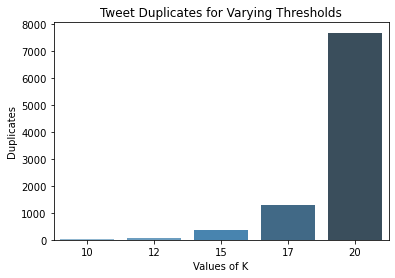

In [55]:
import seaborn as sns
ax = sns.barplot(x = "Values of K", y = "Duplicates", data = df, palette = "Blues_d").set(title = 'Tweet Duplicates for Varying Thresholds')

### 8. US Case Study: Understanding Relationship between Tweets and Covid Progression

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [12]:
path = 'gs://msca-bdp-students-bucket/shared_data/aliahmad/US_CT_Df_Updated'

In [17]:
%%time
combined_df = spark.read.parquet(path)

CPU times: user 4.33 ms, sys: 30 µs, total: 4.36 ms
Wall time: 368 ms


In [18]:
%%time
combined_df = combined_df.toPandas()

CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 690 ms


In [50]:
combined_df.head()

,country,year,month,day,num_tweets,date,cases,deaths,Month_1,Country_1,Week,Day_Cases,Day_Deaths
0,United States,2022,Jan,22,255,1/22/22,70468314,865116,1,United States,4,337384,934
1,United States,2022,Jan,21,302,1/21/22,70130930,864182,1,United States,4,825315,3866
2,United States,2021,Nov,22,205,11/22/21,47851516,773402,11,United States,48,158898,1233
3,United States,2021,Nov,05,357,11/5/21,46395310,753734,11,United States,45,91768,2321
4,United States,2021,Nov,17,229,11/17/21,47390261,766489,11,United States,47,114357,1618


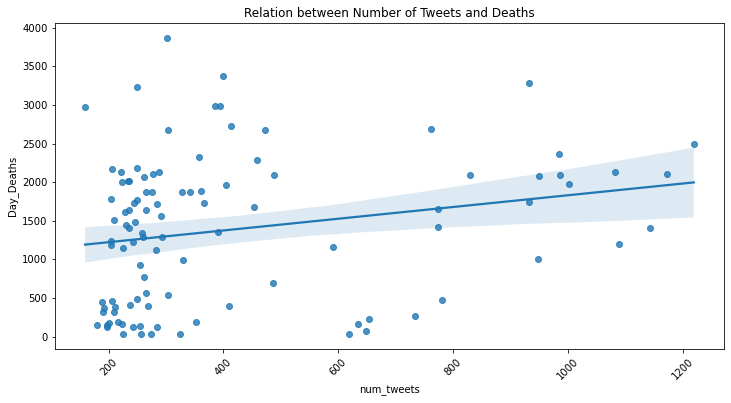

In [53]:
plt.figure(figsize = (12,6))
sns.regplot(x = "num_tweets", y = "Day_Deaths", data = combined_df).set(title = 'Relation between Number of Tweets and Deaths')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);

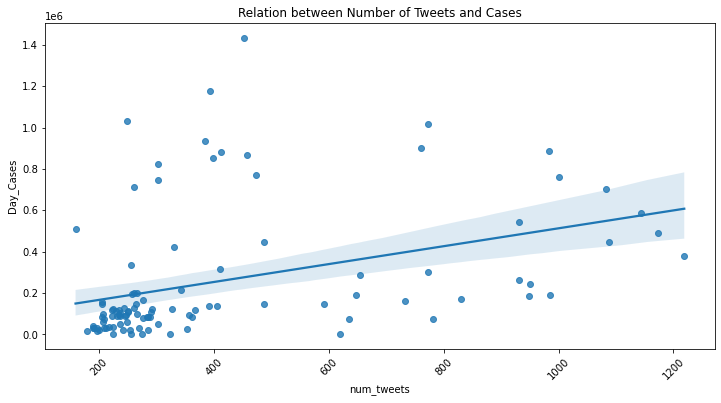

In [54]:
plt.figure(figsize = (12,6))
sns.regplot(x = "num_tweets", y = "Day_Cases", data = combined_df).set(title = 'Relation between Number of Tweets and Cases')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);

### 9. Appendix

In [3]:
path = 'gs://msca-bdp-students-bucket/shared_data/aliahmad/sample_df'

In [4]:
%%time
sample_df = spark.read.parquet(path)

CPU times: user 8.07 ms, sys: 819 µs, total: 8.89 ms
Wall time: 7.67 s


22/03/20 01:52:57 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
type(sample_df)

pyspark.sql.dataframe.DataFrame

In [8]:
sample_df.columns

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'user',
 'withheld_in_countries']

In [10]:
sample_df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo